In [1]:
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
rates = pd.read_csv('./roman_exchange_rates_1729253897.csv')
transactions = pd.read_csv('./roman_transactions_1729253897.csv')

#### Decoding column names of the `rates` table

In [3]:
# Function for converting a Roman numeral to an Arabic numeral
def roman_to_int(roman: str) -> int:
    roman_numerals = {
        'I': 1, 'V': 5, 'X': 10, 'L': 50,
        'C': 100, 'D': 500, 'M': 1000
    }

    total = prev_value = 0
    for i in range(len(roman) - 1, -1, -1):
        current_value = roman_numerals[roman[i]]
        if current_value < prev_value:
            total -= current_value
        else:
            total += current_value
        prev_value = current_value
    return total

In [4]:
# We can notice that the format XXXIV-XII-XXIV
# resembles a date in the format YYYY-MM-DD
rates.head(3)

,col_0,col_1,col_2
0,LXX,XXXIV-XII-XXIV,XL
1,LXX,XXXIV-XII-XXV,XXXIX
2,LXX,XXXIV-XII-XXVI,XL


In [5]:
# Split the column into subcolumns ['Год', 'Месяц', 'День']
# and test the hypothesis that MAX('Месяц') <= 12 and MAX('День') <= 31
rates[['Год', 'Месяц', 'День']] = rates.col_1.str.split('-', expand=True)
rates.drop('col_1', axis=1, inplace=True)

# Apply the function to each Roman numeral value in the DataFrame
rates = rates.applymap(roman_to_int)
rates.head(3)

,col_0,col_2,Год,Месяц,День
0,70,40,34,12,24
1,70,39,34,12,25
2,70,40,34,12,26


Use the known data from the task:  
>... on one day, the exchange rate was as follows: `1 gold = 40 silver = 70 bronze`

In [6]:
# Let’s consider the maximum values of 'col_0' and 'col_2'
# It is evident that max('col_2') <= 42,
# but on one of the days, the values were 1-40-70
# Therefore, 'col_2' represents silver, and 'col_0' represents bronze
rates.describe()

,col_0,col_2,Год,Месяц,День
count,2202.000000,2202.000000,2202.000000,2202.000000,2202.000000
mean,98.386013,32.531789,37.490917,6.536785,15.762489
std,12.899357,6.617075,1.720908,3.461709,8.823443
min,70.000000,22.000000,34.000000,1.000000,1.000000
25%,94.000000,25.000000,36.000000,4.000000,8.000000
50%,100.000000,33.000000,37.000000,7.000000,16.000000
75%,106.000000,39.000000,39.000000,10.000000,23.000000
max,128.000000,42.000000,41.000000,12.000000,31.000000


Let’s define the coin names:
> The most valuable coin was the one whose name derived from the Latin word for "gold"

> ... `denarius` coin ... had a trend of depreciation relative to the gold coin

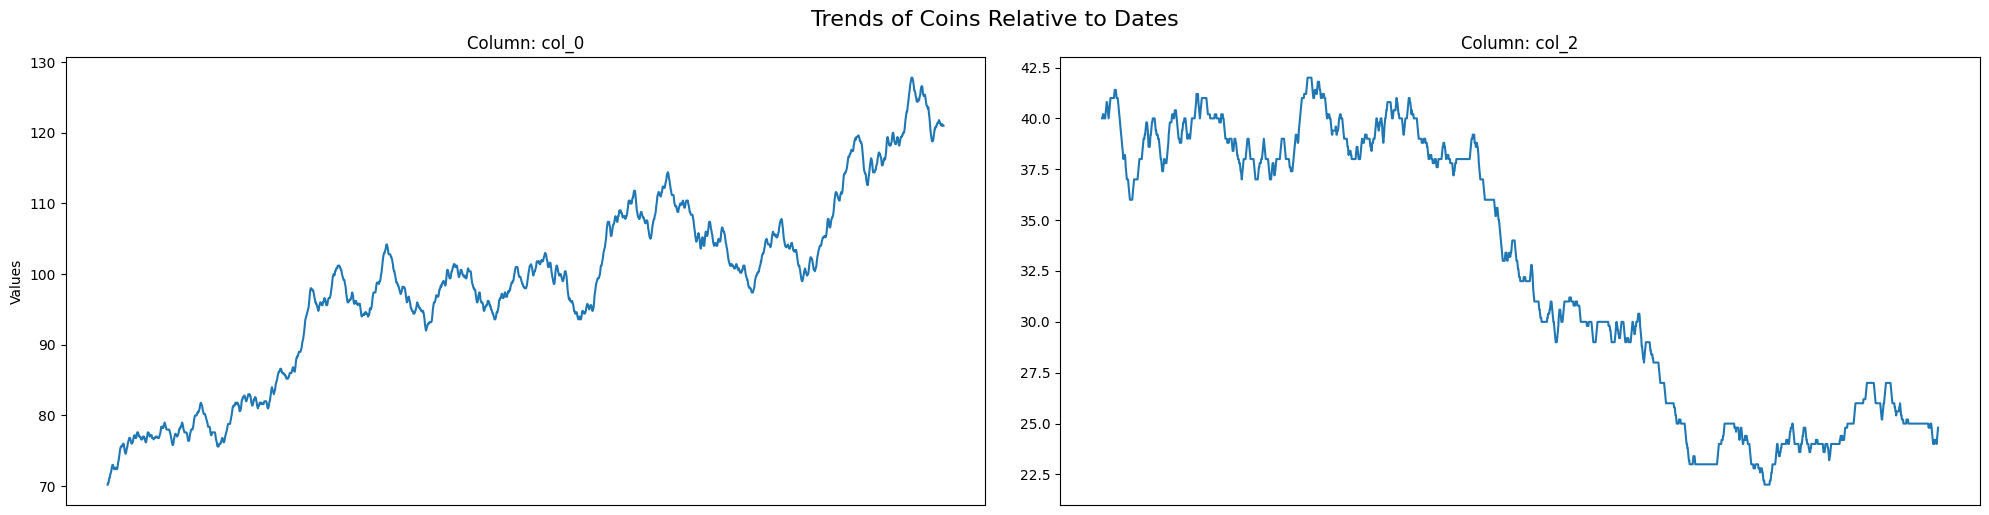

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

for ax, column in zip(axes, ['col_0', 'col_2']):
    sns.lineplot(rates.sort_values(['Год', 'Месяц', 'День'])[column].rolling(5).mean(),
                 ax=ax)
    ax.set_xticks([])
    ax.set_title(f"Column: {column}")

plt.tight_layout()  
axes[0].set_ylabel('Values')
axes[1].set_ylabel('')
fig.text(.5, 1, 'Trends of Coins Relative to Dates',
         ha='center', va='center', fontsize=16);

In [8]:
# The trend of currency devaluation relative to 1 gold coin is observed in 'col_2'
# As a result, we obtain the following table:
rates.rename(columns={'col_0': 'Quinarius', 'col_2': 'Denarius'}, inplace=True)
rates.head(3)

,Quinarius,Denarius,Год,Месяц,День
0,70,40,34,12,24
1,70,39,34,12,25
2,70,40,34,12,26


#### Decoding column names of the `transactions` table
The first column names that we can immediately restore in the `transactions` table are `Товар` and `Валюта`

In [9]:
transactions.rename(columns={'col_0': 'Товар', 'col_4': 'Валюта'}, inplace=True)

for column in ['col_1', 'col_2', 'col_3', 'col_5', 'col_6', 'col_7']:
    transactions[column] = transactions[column].apply(roman_to_int)
transactions.head(3)

,Товар,col_1,col_2,col_3,Валюта,col_5,col_6,col_7
0,Muniv,39,8,31,Quinarius,8,29,129
1,Murytub,39,9,121,Quinarius,5,8,125
2,Murytub,40,8,117,Aureus,5,21,5


In [10]:
# Let’s consider the descriptive statistics of each column
# and the number of unique values
transactions.describe()

,col_1,col_2,col_3,col_5,col_6,col_7
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,37.511150,6.484150,117.212650,5.938400,15.483400,525.359350
std,1.708222,3.451745,61.245627,1.674767,8.871238,749.277647
min,35.000000,1.000000,3.000000,1.000000,1.000000,1.000000
25%,36.000000,3.000000,41.000000,5.000000,8.000000,153.000000
50%,38.000000,6.000000,134.000000,6.000000,15.000000,349.000000
75%,39.000000,10.000000,165.000000,7.000000,23.000000,573.000000
max,41.000000,12.000000,278.000000,12.000000,31.000000,4249.000000


In [11]:
transactions.nunique()

Товар        5
col_1        7
col_2       12
col_3      240
Валюта       3
col_5       12
col_6       31
col_7     2023
dtype: int64

Conclusions based on the obtained data:
* `col_6` has a maximum value of 31 and 31 unique values — `День`
* `col_7` has very large values and 2023 unique values — `Цена`
* `col_3` has the second largest value and 240 unique values — `Количество`
* `col_1` has a value range of [35, 41] — `Год`

Now, we need to determine the values for `col_2` and `col_5`, as both have the value 12

In [12]:
transactions.rename(columns={'col_1': 'Год', 'col_3': 'Количество',
                             'col_6': 'День', 'col_7': 'Цена'}, inplace=True)

#### Restoring the column names for `col_2` and `col_5`
> The favor of the gods was determined daily in the Temple of Jupiter by tossing 12 fair coins

Let’s test the hypothesis, which asserts that if there was a change in values in the examined column  
for different transactions on the same day, it is not a sign of divine favor

In [13]:
# Check that 'col_5' is the index of divine favor, and 'col_2' represents the month
transactions.groupby(['Год', 'col_2', 'День']) \
    .agg({'col_5': pd.Series.nunique}) \
    .col_5 \
    .nunique()

1

In [14]:
# check that col_2 is the index of divine favor, and col_5 represents the month
transactions.groupby(['Год', 'col_5', 'День']) \
    .agg({'col_2': pd.Series.nunique}) \
    .col_2 \
    .nunique()

7

The hypothesis was confirmed in the second case. Now, let’s restore the entire original table

In [15]:
transactions.rename(columns={'col_2': 'Месяц', 'col_5': 'Индекс'}, inplace=True)
transactions.head(3)

,Товар,Год,Месяц,Количество,Валюта,Индекс,День,Цена
0,Muniv,39,8,31,Quinarius,8,29,129
1,Murytub,39,9,121,Quinarius,5,8,125
2,Murytub,40,8,117,Aureus,5,21,5


#### Restoring the product names
Let’s start with the following fact:
> The `quantity` of `silk` sold was distributed exponentially, while the quantity of `grain` was distributed uniformly.  
The quantity of the product sold is considered for each transaction



In [16]:
products = transactions.Товар.unique().tolist()
ALPHA = 0.05
SAMPLE_SIZE = 300

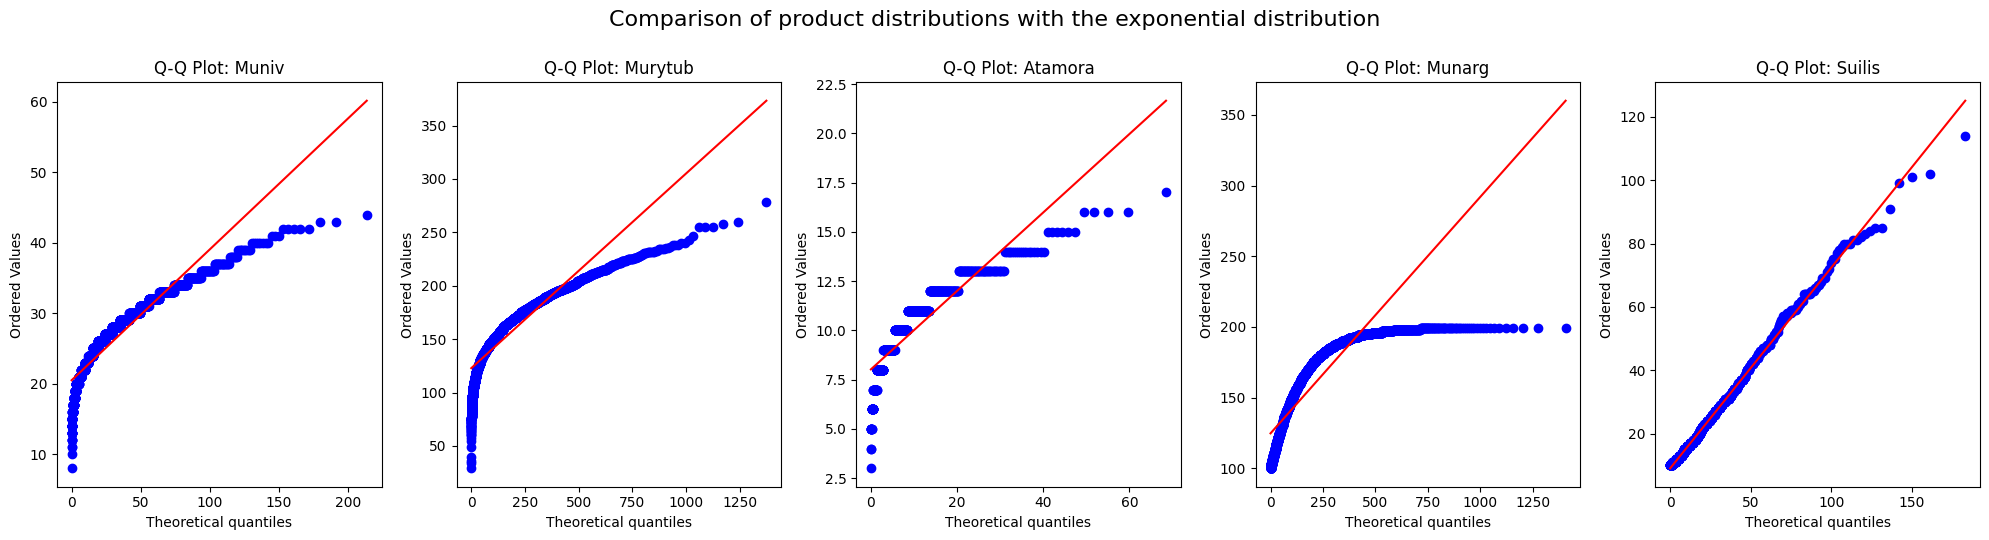

In [17]:
# Comparison of the distribution with the theoretical exponential distribution
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for ax, product in zip(axes, products):
    sample_data = transactions.query('Товар == @product').Количество
    
    # Let’s determine the skewness and the intensity (lambda)
    # for each empirical distribution
    skewness = .0
    lambda_estimate = 1 / sample_data.mean()

    # Kolmogorov-Smirnov Test
    # The Kolmogorov-Smirnov test fails to detect the distribution match,
    # although the QQ-plot clearly shows that 'Suilis'
    # has a distribution similar to the exponential one
    pvalue = stats.kstest(sample_data, 'expon', args=(skewness, lambda_estimate)).pvalue
    if pvalue > ALPHA:
        print(f'Kolmogorov-Smirnov Test\n' \
              f'No statistical significance was found for {product} — the distribution is exponential\n' \
              f'Probability: {pvalue.round(3)} | Significance level: {ALPHA}\n' \
              f'Sample size: {len(sample_data)}    | Skewness: {skewness} | Lambda: {1 / lambda_estimate}')

    # QQ-plot
    stats.probplot(sample_data, dist='expon',
                   sparams=(skewness, 1 / lambda_estimate), plot=ax)
    
    ax.set_title(f'Q-Q Plot: {product}')

plt.tight_layout()
fig.text(.5, 1.05, 'Comparison of product distributions with the exponential distribution',
         ha='center', va='center', fontsize=16);
# The KS-test shows statistically significant differences for all samples (possibly due to the low right tail)
# Therefore, we determine the best match based on the QQ-plot

Kolmogorov-Smirnov Test
No statistical significance was found for Munarg — the distribution is uniform
Probability: 0.185  | Significance level: 0.05
Sample size: 300    | Lower bound: 100 | Interval length: 99


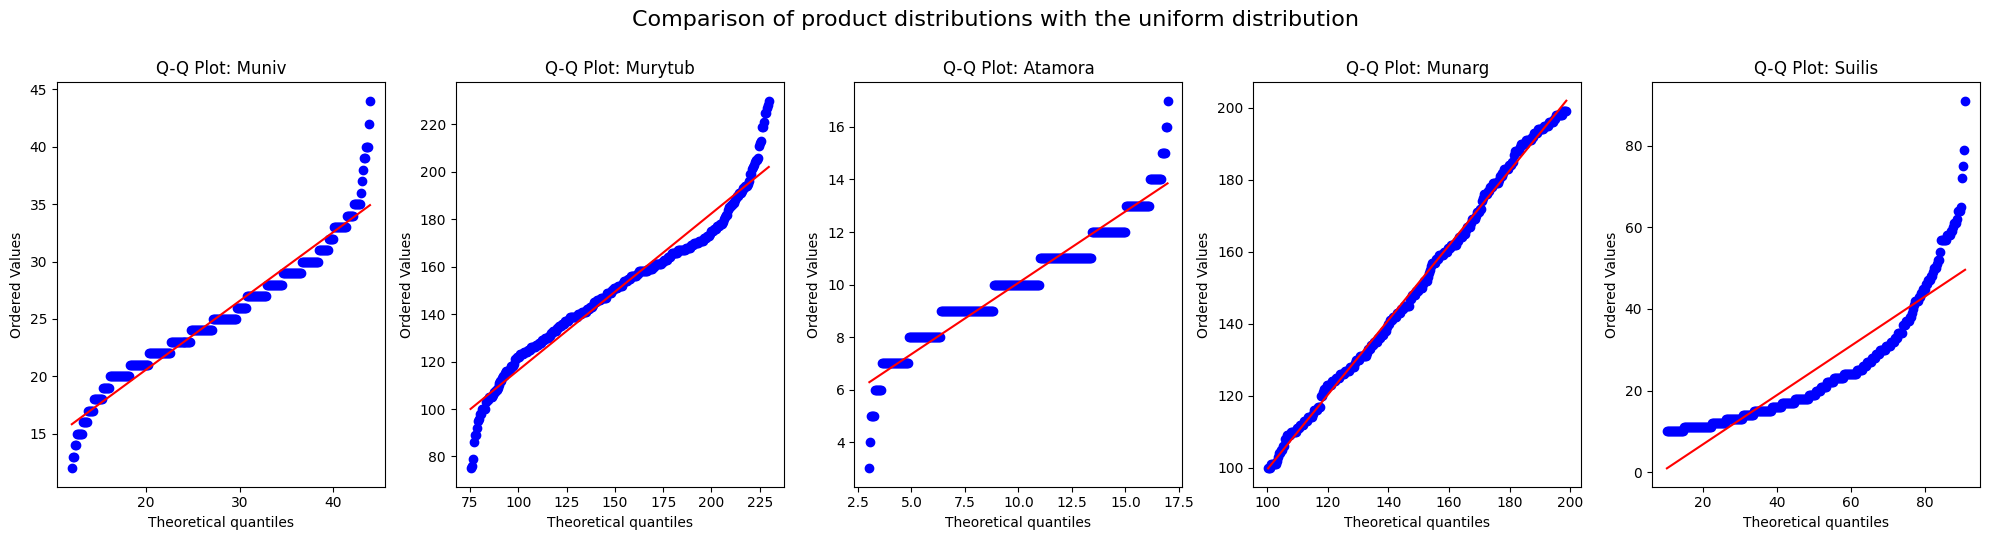

In [18]:
# Comparison of the distribution with the theoretical uniform distribution
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for ax, product in zip(axes, products):
    # Since there is a large amount of data, the KS-test will yield inaccurate results.
    # We will perform data sampling
    sample_data = transactions.query('Товар == @product') \
        .Количество \
        .sample(n=SAMPLE_SIZE, random_state=42)

    # Let’s determine the lower bound and
    # the interval length of the uniform distribution
    a = sample_data.min()
    scale = sample_data.max() - a

    # Kolmogorov-Smirnov Test
    pvalue = stats.kstest(sample_data, 'uniform', args=(a, scale)).pvalue
    if pvalue > ALPHA:
        print(f'Kolmogorov-Smirnov Test\n' \
              f'No statistical significance was found for {product} — the distribution is uniform\n' \
              f'Probability: {pvalue.round(3)}  | Significance level: {ALPHA}\n' \
              f'Sample size: {SAMPLE_SIZE}    | Lower bound: {a} | Interval length: {scale}')
    
    # QQ-plot
    stats.probplot(sample_data, dist='uniform',
                   sparams=(a, scale), plot=ax)
    
    ax.set_title(f'Q-Q Plot: {product}')

plt.tight_layout()
fig.text(.5, 1.05, 'Comparison of product distributions with the uniform distribution',
         ha='center', va='center', fontsize=16);

Using the QQ-Plot and the Kolmogorov-Smirnov test, we were able to determine:
1. `Suilis` follows an exponential distribution => `Suilis` — `Шелк`
2. `Munarg` follows a uniform distribution => `Munarg` — `Зерно`

Now, let's determine the names of the `Масло` and `Специи`. We will use the fact:
> In one of the years, a severe drought occurred,  
which caused a significant spike in the average `price` of `oil` for several months,  
while the average `price` of `spices`, on the contrary, fell

In [19]:
def format_month(month: int) -> str:
    if month < 10:
        return '0' + str(month)
    return str(month)

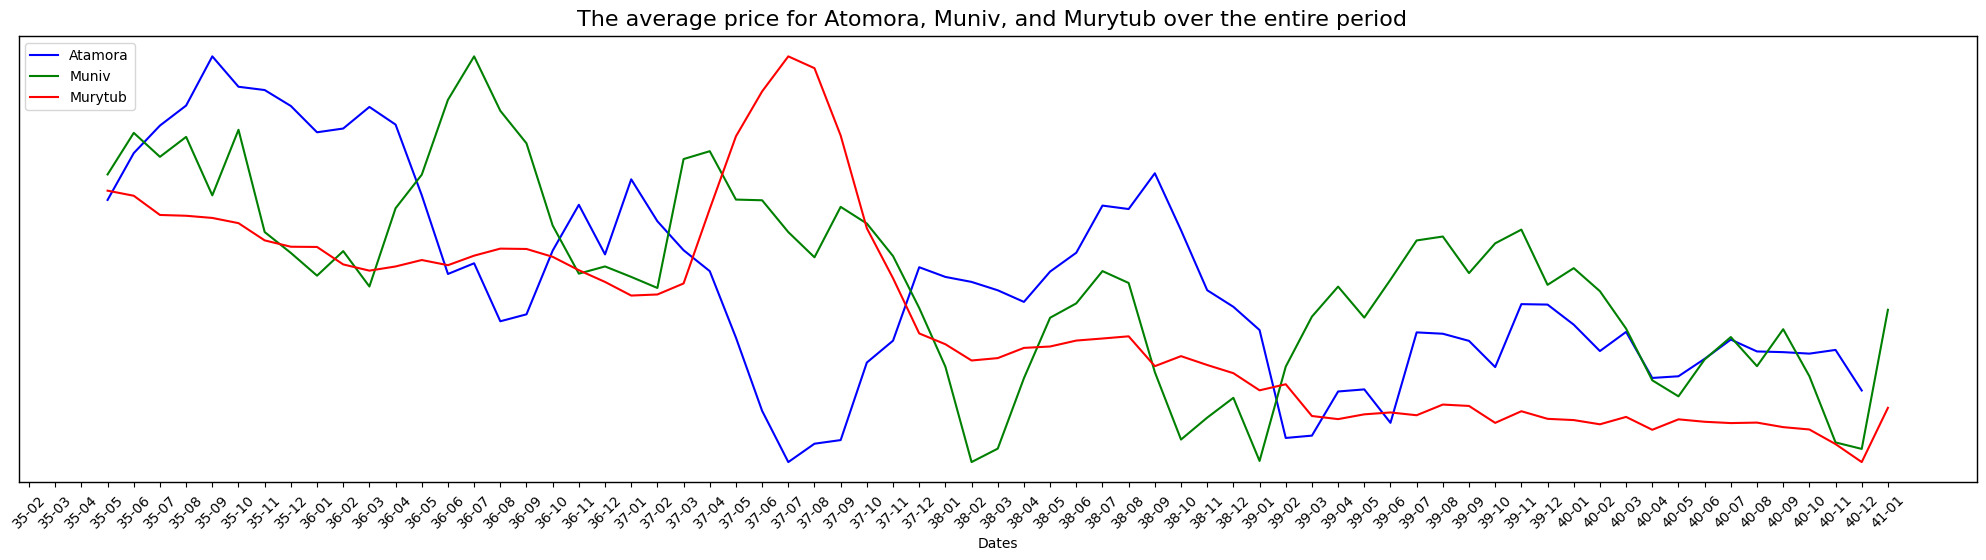

In [20]:
# Calculate the average price for each product in each month
average_prices = transactions.query('Товар not in ["Suilis", "Munarg"]') \
    .groupby(['Товар', 'Год', 'Месяц'], as_index=False) \
    .agg({'Цена': np.mean})

# Convert the year and month into a date format of YYYY-MM
# This is necessary for ordering the values on the X-axis of the plot
# If the month is not converted to the format 1 -> 01, then lexicographically,
# 1 month < 12 month < 2 month
average_prices.Год = average_prices.Год.astype(str)
average_prices.Месяц = average_prices.Месяц.apply(format_month)
average_prices['Дата'] = average_prices.Год + '-' + average_prices.Месяц

fig, line = plt.subplots(figsize=(20, 5))
line.set_yticks([])
curr_line = line

for color, product in zip(['blue', 'green', 'red'], average_prices.Товар.unique()):
    curr_line.plot(
        average_prices.query('Товар == @product').Дата,
        average_prices.query('Товар == @product').Цена.rolling(5).mean(),
        label=product,
        color=color)
    curr_line = line.twinx()
    curr_line.set_yticks([])

plt.tight_layout()
fig.legend(average_prices.Товар.unique(), loc="upper left", bbox_to_anchor=(.013, .97))
line.set_xlabel('Dates')
line.tick_params(axis='x', rotation=45)
fig.text(.5, 1.004, 'The average price for Atomora, Muniv, and Murytub over the entire period',
         ha='center', va='center', fontsize=16);

Based on the plotted graph, we need to take the year as $\Delta$  
and find the simultaneous largest and smallest jumps of two different line plots  

* [35-02, 36-01] — `Murytub` and `Atamora` are increasing, while Muniv decreases towards the end of the year  
* [36-02, 37-01] — A sharp jump in `Muniv` and `Atamora`, but relative to the overall trend, `Atamora's` jump is not significant  
* [37-02, 38-01] — <b>An opposite trend is observed with maximum jumps for `Atamora` and `Murytub`</b>  
* [38-02, 39-01] — The trend is observed for `Muniv` and `Atamora`, while `Murytub` steadily decreases in price  
* [39-02, 40-01] — During this period, almost all prices are increasing  
* [40-02, 41-01] — No sharp jumps during this period

We have the following restored names:  
```Suilis: Шелк, Munarg: Зерно, Murytub: Масло, Atamora: Специи, Muniv: ?```

To decode the last product, the product names need to be written in reverse order    
```Silius: Шелк, Granum: Зерно, Butyrum: Масло, Aromata: Специи, Vinum: ?```  

Get familiar Latin words and easily identify the last word  
```Silius: Шелк, Granum: Зерно, Butyrum: Масло, Aromata: Специи, Vinum: Вино```

In [21]:
def decode_name(product_name: str) -> str:
    decoded = {
        'Suilis': 'Шелк', 'Munarg': 'Зерно',
        'Murytub': 'Масло', 'Atamora': 'Специи',
        'Muniv': 'Вино'
    }
    return decoded.get(product_name, product_name)

In [22]:
transactions.Товар = transactions.Товар.apply(decode_name)
transactions.head(3)

,Товар,Год,Месяц,Количество,Валюта,Индекс,День,Цена
0,Вино,39,8,31,Quinarius,8,29,129
1,Масло,39,9,121,Quinarius,5,8,125
2,Масло,40,8,117,Aureus,5,21,5


#### Get the sorted list of products by sales revenue

In [23]:
full_data = transactions.merge(rates, how='left', on=['Год', 'Месяц', 'День'])
full_data.head(3)

,Товар,Год,Месяц,Количество,Валюта,Индекс,День,Цена,Quinarius,Denarius
0,Вино,39,8,31,Quinarius,8,29,129,100,23
1,Масло,39,9,121,Quinarius,5,8,125,101,23
2,Масло,40,8,117,Aureus,5,21,5,120,27


In [24]:
# Convert the prices to a single currency, 'Quinarius'
# 'Aureus' or 'Denarius' = Price * Quinarius
full_data['Цена'] = np.where(full_data['Валюта'].isin(['Aureus', 'Denarius']),
    full_data['Цена'] * full_data['Quinarius'], full_data['Цена'])

# Calculate the revenue for a specific sale
full_data['Revenue'] = full_data.Цена * full_data.Количество
# Calculate the total revenue for each product over the entire period
total_revenue = full_data.groupby('Товар', as_index=False) \
    .agg({'Revenue': sum}) \
    .sort_values('Revenue', ascending=False) \
    .Товар \
    .unique() \
    .tolist()


In [25]:
print(','.join(transactions.columns.tolist()))
print(','.join(total_revenue))

Товар,Год,Месяц,Количество,Валюта,Индекс,День,Цена
Масло,Зерно,Шелк,Вино,Специи
